# EpiEstim (python)


## Configure the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-poster')
from datetime import datetime as dt
from datetime import timedelta
import glob
    
from Reff_functions import *
from Reff_constants import *
from scipy.stats import gamma

In [3]:
#Code taken from read_in_cases from Reff_functions. Preprocessing was not helpful for this situation.
def read_cases_lambda(case_file_date):
    path = "../data/COVID-19 UoM "+case_file_date+"*.xlsx"

    for file in glob.glob(path):
        df_NNDSS = pd.read_excel(file,
                           parse_dates=['SPECIMEN_DATE','NOTIFICATION_DATE','NOTIFICATION_RECEIVE_DATE','TRUE_ONSET_DATE'],
                           dtype= {'PLACE_OF_ACQUISITION':str})
        df_NNDSS.PLACE_OF_ACQUISITION.fillna('00038888',inplace=True) #Fill blanks with simply unknown

       # df_NNDSS['date_inferred'] = df_NNDSS.TRUE_ONSET_DATE
      #  df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.TRUE_ONSET_DATE.isna()].NOTIFICATION_DATE - timedelta(days=5)
      #  df_NNDSS.loc[df_NNDSS.date_inferred.isna(),'date_inferred'] = df_NNDSS.loc[df_NNDSS.date_inferred.isna()].NOTIFICATION_RECEIVE_DATE - timedelta(days=6)    
    df_NNDSS['imported'] = df_NNDSS.PLACE_OF_ACQUISITION.apply(lambda x: 1 if x[-4:]=='8888' and x != '00038888' else 0)
    df_NNDSS['local'] = 1 - df_NNDSS.imported

    df_interim = df_NNDSS[['NOTIFICATION_RECEIVE_DATE','STATE','imported','local']] 
    #df_interim = df_interim[~np.isnat(df_interim.NOTIFICATION_DATE)] #Get rid of non-existent dates.
    # Importantly, imported and local are indicator variables in df_interim.

    #df_state = df_NNDSS[['NOTIFICATION_DATE','STATE','imported','local']].groupby(['STATE','NOTIFICATION_DATE']).sum()
    return(df_interim)

def tidy_cases_lambda(interim_data, remove_territories=True):
    #Remove non-existent notification dates
    interim_data = interim_data[~np.isnat(interim_data.NOTIFICATION_RECEIVE_DATE)]
    
    #Filter out territories
    if(remove_territories):
        df_linel = interim_data[(interim_data['STATE']!='NT') & (interim_data['STATE']!='ACT')]

    #Melt down so that imported and local are no longer columns. Allows multiple draws for infection date.
    #i.e. create linelist data
    df_linel = df_linel.melt(id_vars = ['NOTIFICATION_RECEIVE_DATE','STATE'], var_name = 'SOURCE',value_name='n_cases')

    #Reset index or the joining doesn't work
    df_linel = df_linel[df_linel.n_cases!=0]
    df_linel = df_linel.reset_index(drop=True)
    return(df_linel)



df_interim = read_cases_lambda('29Jun')

df_linel = tidy_cases_lambda(df_interim)

## Part 1: Inferring infection dates
$\Lambda$ depends on the infection date (ID), while the data contains the notification date (ND). We obtain ID through the following relationship:
$$
ID = ND - reporting\_delay - incubation\_period.
$$

A gamma distribution was fitted to case data using the MLE algorithm to produce distributions for reporting delay and incubation period. 


In [9]:
##uncomment for debugging
# notification_dates = df_linel['NOTIFICATION_DATE']
# mean_rd = 5.47
# sd_rd = 4.04
# mean_inc = 2.0
# sd_inc = 1.41
# nreplicates = 3

##gamma draws take arguments (shape, scale)
def draw_inf_dates(df_linelist, mean_rd=5.47, sd_rd=4.04,
                    mean_inc=2.0, sd_inc=1.41, nreplicates=1):

    notification_dates = df_linelist['NOTIFICATION_RECEIVE_DATE']
    nsamples = notification_dates.shape[0]

    #    DEFINE DELAY DISTRIBUTION
    #     mean_rd = 5.47
    #     sd_rd = 4.04
    scale_rd = mean_rd/(sd_rd)**2
    shape_rd = mean_rd/scale_rd

    # DEFINE INCUBATION PERIOD DISTRIBUTION
    #     mean_inc = 2.0
    #     sd_inc = 1.41
    scale_inc = mean_inc/(sd_inc)**2
    shape_inc = mean_inc/scale_inc

    #Draw from distributions - these are long vectors
    inc_period = np.random.gamma(shape_inc, scale_inc, size = (nsamples*nreplicates))
    rep_delay = np.random.gamma(shape_rd, scale_rd, size = (nsamples*nreplicates))

    #infection date is id_nd_diff days before notification date. This is also a long vector.
    id_nd_diff = inc_period + rep_delay

    #Minutes aren't included in df. Take the ceiling because the day runs from 0000 to 2359. This can still be a long vector.
    whole_day_diff = np.ceil(id_nd_diff) 
    time_day_diffmat = whole_day_diff.astype('timedelta64[D]').reshape((nsamples, nreplicates))

    #Vector must be coerced into a nsamples by nreplicates array. Then each column must be subtracted from notification_dates. 
    #Subtract days off of notification dates.

    notification_mat = np.tile(notification_dates, (nreplicates,1)).T #notification_dates is repeated as a column nreplicates times.

    infection_dates = notification_mat - time_day_diffmat

    #Make infection dates into a dataframe
    datecolnames = [*map(str,range(nreplicates))]
    infdates_df = pd.DataFrame(infection_dates,columns = datecolnames)
    
    #Uncomment this if theres errors
    #print([df_linelist.shape, infdates_df.shape])
    
    
    #Combine infection dates and original dataframe
    df_inf = pd.concat([df_linelist, infdates_df], axis=1, verify_integrity=True)

    return(df_inf)

In [10]:
df_inf = draw_inf_dates(df_linel, nreplicates=1000)
df_inf.head()

,NOTIFICATION_RECEIVE_DATE,STATE,SOURCE,n_cases,0,1,2,3,4,5,...,990,991,992,993,994,995,996,997,998,999
0,2020-06-26,NSW,imported,1,2020-06-20,2020-06-21,2020-06-18,2020-06-18,2020-06-16,2020-06-16,...,2020-06-17,2020-06-20,2020-06-18,2020-06-19,2020-06-19,2020-06-17,2020-06-18,2020-06-18,2020-06-19,2020-06-19
1,2020-06-27,NSW,imported,1,2020-06-21,2020-06-20,2020-06-21,2020-06-18,2020-06-17,2020-06-17,...,2020-06-22,2020-06-18,2020-06-19,2020-06-15,2020-06-18,2020-06-20,2020-06-16,2020-06-16,2020-06-18,2020-06-19
2,2020-06-27,NSW,imported,1,2020-06-16,2020-06-19,2020-06-19,2020-06-19,2020-06-18,2020-06-21,...,2020-06-19,2020-06-15,2020-06-18,2020-06-21,2020-06-14,2020-06-18,2020-06-18,2020-06-18,2020-06-22,2020-06-15
3,2020-06-27,NSW,imported,1,2020-06-20,2020-06-19,2020-06-21,2020-06-14,2020-06-18,2020-06-16,...,2020-06-18,2020-06-21,2020-06-18,2020-06-19,2020-06-19,2020-06-19,2020-06-21,2020-06-18,2020-06-20,2020-06-16
4,2020-06-27,NSW,imported,1,2020-06-20,2020-06-14,2020-06-19,2020-06-15,2020-06-19,2020-06-18,...,2020-06-20,2020-06-19,2020-06-19,2020-06-18,2020-06-15,2020-06-16,2020-06-16,2020-06-20,2020-06-21,2020-06-20


In [11]:
def index_by_infection_date(infections_wide):
    datecolnames = [*infections_wide.columns[4:]]
    df_combined = infections_wide[['STATE','SOURCE',datecolnames[0],'n_cases']].groupby(['STATE', datecolnames[0],'SOURCE']).sum()

    #For each column (cn=column number): concatenate each sample as a column.
    for cn in range(1,len(datecolnames)):
        df_addin = infections_wide[['STATE','SOURCE',datecolnames[cn],'n_cases']].groupby(['STATE', datecolnames[cn],'SOURCE']).sum()
        df_combined = pd.concat([df_combined,df_addin], axis=1, ignore_index = True)

    #NaNs are inserted for missing values when concatenating. If it's missing, there were zero infections
    df_combined[np.isnan(df_combined)]=0
    #Rename the index.
    df_combined.index.set_names(["STATE","INFECTION_DATE","SOURCE"], inplace=True)

    #return(df_combined)

    ##INCLUDE ALL DAYS WITH ZERO INFECTIONS IN THE INDEX AS WELL.

    # Reindex to include days with zero total infections.
    local_infs = df_combined.xs('local',level='SOURCE')
    imported_infs = df_combined.xs('imported',level='SOURCE')
    statelist = [*df_combined.index.get_level_values('STATE').unique()]

    #Should all states have the same start date? Current code starts from the first case in each state.
    #For the same start date:
    local_statedict = dict(zip(statelist, np.repeat(None, len(statelist))))
    imported_statedict = dict(zip(statelist, np.repeat(None, len(statelist))))

    #Determine start date as the first infection date for all. 
    #start_date = np.datetime64("2020-02-01")
    start_date = df_combined.index.get_level_values('INFECTION_DATE').min()

    #Determine end dates as the last infected date by state.
    index_only = df_combined.index.to_frame()
    index_only = index_only.reset_index(drop=True)
    maxdates = index_only.groupby(['STATE'])['INFECTION_DATE'].max()

    for aus_state in statelist:
        state_data = local_infs.xs(aus_state, level='STATE')
        #start_date = state_data.index.min()

        #dftest.index=dftest.reindex(alldates, fill_value=0)

        alldates = pd.date_range(start_date, maxdates[aus_state]) #All days from start_date to the last infection day.
        local_statedict[aus_state] = state_data.reindex(alldates, fill_value=0)

    for aus_state in statelist:
        state_data = imported_infs.xs(aus_state, level='STATE')
        alldates = pd.date_range(start_date, maxdates[aus_state])
        imported_statedict[aus_state] = state_data.reindex(alldates, fill_value=0)

    #Convert dictionaries to data frames
    df_local_inc_zeros = pd.concat(local_statedict)
    df_local_inc_zeros['SOURCE']='local'
    df_imp_inc_zeros = pd.concat(imported_statedict)
    df_imp_inc_zeros['SOURCE']='imported'

    #Merge dataframes and reindex. 
    df_inc_zeros = pd.concat([df_local_inc_zeros, df_imp_inc_zeros])

    df_inc_zeros = df_inc_zeros.reset_index()
    df_inc_zeros= df_inc_zeros.groupby(['level_0',"level_1","SOURCE"]).sum()
    df_inc_zeros.index = df_inc_zeros.index.rename(['STATE','INFECTION_DATE',"SOURCE"])

    return(df_inc_zeros)

df_inc_zeros = index_by_infection_date(df_inf)
df_inc_zeros.head()

0    1    2    3    4    5    6    7    8    \
STATE INFECTION_DATE SOURCE                                                  
NSW   2020-01-04     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-05     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-06     imported  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                               9    ...  990  991  992  993  994  995  996  \
STATE INFECTION_DATE SOURCE         ...                                      
NSW   2020-01-04     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-05     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
                     local     0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
      2020-01-06     imported  0.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                               997  998  999  
STATE INFECTION_DATE SOURCE                   
NSW   2020-01-04     imported  0.0  0.0  0.0  
                     local     0.0  0.0  0.0  
      2020-01-05     imported  0.0  0.0  0.0  
                     local     0.0  0.0  0.0  
      2020-01-06     imported  0.0  0.0  0.0  

[5 rows x 1000 columns]

In [12]:
# unit test to ensure min and max dates captures all imputations of 
# infection dates
summary = np.sum(df_inc_zeros, axis=0).describe() #Differences in numbers: start date?
assert summary.loc['max'] == summary.loc['min'], "Min number of cases does not match max number, dates have truncated cases"


## Part 2: Calculating Lambda

$$
\Lambda_t(w_s) = \sum_{s=1}^t (I_{t-s}^{local} + I_{t-s}^{imported})w_s = \sum_{s=1}^t I_{t-s}w_s,
$$
where $w_s$ is the probability that the generation interval is $s$ and $I_t$ is the number of infected individuals at time $t$. 

### Part 2a: Discretizing the gamma generation interval distribution

In the formula for $\Lambda_t$, we sum over $w$. We should consider generation interval as a discrete random variable here. 

In [13]:
def generate_lambda(infection_dates, mean_gen=2.5, sd_gen=1.75, trunc_day=21,shift=0):
    """
    Given array of infection_dates (N_dates by N_samples), where values are possible
    number of cases infected on this day, generate the force of infection Lambda_t,
    a N_dates-tau by N_samples array.
    """
    from scipy.stats import gamma
 
    scale_gen = mean_gen/(sd_gen)**2
    shape_gen = mean_gen/scale_gen
    

    xmids = [x+shift for x in range(trunc_days+1)] #Find midpoints for discretisation
    gamma_vals = gamma.pdf(xmids, a=shape_gen, scale=scale_gen) #double check parameterisation of scipy
    #renormalise the pdf
    disc_gamma = gamma_vals/sum(gamma_vals)
    
    ws = disc_gamma[:trunc_day]
    lambda_t = np.zeros(shape=(infection_dates.shape[0]-trunc_day+1, infection_dates.shape[1]))
    for n in range(infection_dates.shape[1]):
        lambda_t[:,n] = np.convolve(infection_dates[:,n], ws, mode='valid')
    return lambda_t
    
    
def lambda_all_states(df_infection):
    """
    Use geenrate lambda on every state
    """
    statelist = [*infection_dates.index.get_level_values('STATE').unique()]
    
    lambda_dict ={}
    for state in statelist:
        lambda_dict[state] = generate_lambda(df_infection.xs(state, level='STATE'))
    
    return lambda_dict

In [14]:
#Define gamma distribution for generation interval
mean_gen = 2.5
sd_gen = 1.75
scale_gen = mean_gen/(sd_gen)**2
shape_gen = mean_gen/scale_gen


In [15]:
trunc_days = 21
shift=0
xmids = [x+shift for x in range(trunc_days+1)] #Find midpoints for discretisation
gamma_vals = gamma.pdf(xmids, a=shape_gen, scale=scale_gen)
disc_gamma = gamma_vals/sum(gamma_vals)

In [16]:
#Discretisation error check (should sum to 1)

print("Sum of gamma values is " + str(sum(gamma_vals))+"; \n Sum of discretised gamma values is " + str(sum(disc_gamma)))

Sum of gamma values is 0.9936691617045523; 
 Sum of discretised gamma values is 1.0000000000000002


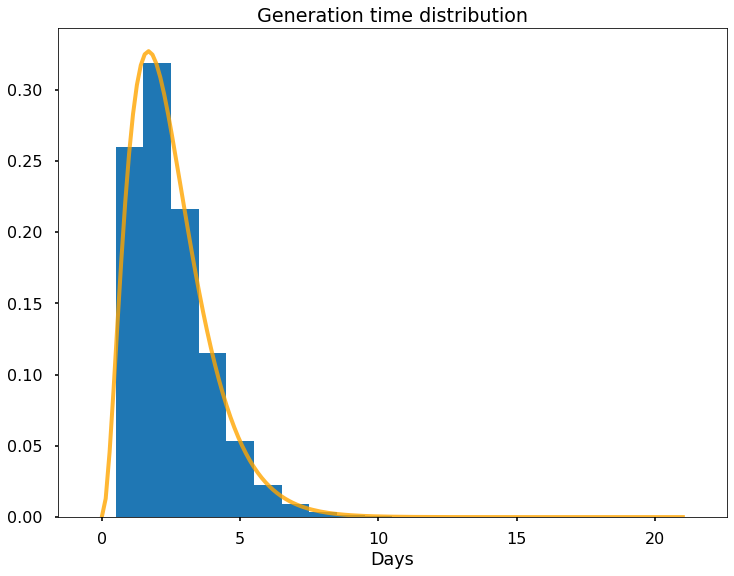

In [17]:
xrange = np.linspace(0,trunc_days,150)
fig,ax = plt.subplots(figsize=(12,9))
w = ax.bar(xmids,height=disc_gamma, width=1)
ax.set_title("Generation time distribution")
ax.plot(xrange, gamma.pdf(xrange, a=shape_gen, scale=scale_gen), linewidth=4,alpha=0.8, color="orange")
ax.set_xlabel('Days')
plt.show()

### Part 2b: Actually calculating $\Lambda$

In [39]:
#ws is the discretised gamma distribution; reversed due to the formula for lambda t.
ws = [*reversed(disc_gamma[1:(trunc_days+1)])]

#Calculate lambda t for a given t in one state. 
def calculate_lambda_t(state_df, t, trunc_days = 21, ws=ws):
    #t = predict_date_range[30]
    #state_df = input_state

    tstart= t-np.timedelta64(trunc_days,'D')
    relevant_dates = pd.date_range(tstart, t-np.timedelta64(1,'D'))
    reldates_df = state_df.loc[relevant_dates]

    #Dates don't matter, since we're calculating lambda t for t = t.
    reldates_df = reldates_df.reset_index(drop=True)
    ws_mat = pd.DataFrame(np.tile(ws, (reldates_df.shape[1],1)).T)

    #lambda_t=sum(reldates*ws)
    lambda_t = np.sum(reldates_df.mul(ws_mat), axis=0)
    return(lambda_t)

#Loop over states and times to calculate all lambda t's
#Input: imported/local counts of infections by date and state. Each column should be a different sample.
#Output: Lambda t by date and state. Each column corresponds to a different original sample. 
def calculate_all_lambdas(infection_df):

    #Depending on data format, flatten if necessary
    if type(infection_df.index)!=pd.RangeIndex:
        infection_df = infection_df.reset_index()
    
    #Create data frame with the total number of infections.
    I_total = infection_df.groupby(['STATE',"INFECTION_DATE"]).sum()
    
    #Find states and preallocate to dict
    statelist = [*I_total.index.get_level_values('STATE').unique()]
    state_dict = dict(zip(statelist, np.repeat(None, len(statelist))))
    
    predict_reff_from = np.datetime64('2020-02-01')

    #Calculate Reff for each state.
    for state in statelist: 
        #print(state)
        input_state_df = I_total.xs(state, level='STATE')
        tmax = input_state_df.index.get_level_values('INFECTION_DATE').max()
        predict_date_range = pd.date_range(predict_reff_from, tmax)

        date_dict = dict(zip(predict_date_range, np.repeat(None, len(predict_date_range))))

        #Find lambda t for every day.
        for t in predict_date_range:
            #print(t)
            date_dict[t] = calculate_lambda_t(input_state_df, t).to_numpy()


        state_dict[state]=date_dict

    #Convert dict to a dataframe 
    lambda_df = pd.DataFrame.from_dict({(i,j): state_dict[i][j] 
                                for i in state_dict.keys() 
                                for j in state_dict[i].keys()},
                                orient='index')
    lambda_df.index = pd.MultiIndex.from_tuples(lambda_df.index,names = ['STATE','INFECTION_DATE'])
    
    return(lambda_df)


In [40]:
lambdas = calculate_all_lambdas(df_inc_zeros)


## 3. Sample from the posterior

Using Cori et al. 2013, the posterior distribution of $R_{t,\tau}$ is a Gamma distribution with parameters shape and scale

\begin{equation}
\left( a + \sum^t_{s = t - \tau +1} I_s , \frac{1}{\frac{1}{b} + \sum^t_{ s = t-\tau + 1} \Lambda_s } \right)
\end{equation}

In [20]:
def Reff_from_case(cases_by_infection, lamb, prior_a=1, prior_b=5, tau=7, samples=1000):
    """
    Using Cori at al. 2013, given case incidence by date of infection, and the force
    of infection \Lambda_t on day t, estimate the effective reproduction number at time
    t with smoothing parameter \tau.
    
    cases_by_infection: A T by N array, for T days and N samples 
    lamb : A T by N array, for T days and N samples
    """
    csum_incidence = np.cumsum(cases_by_infection, axis = 0)
    #remove first few incidences to align with size of lambda
    # Generation interval length 20
    csum_incidence = csum_incidence[20:,:]
    csum_lambda = np.cumsum(lamb, axis =0)
    
    roll_sum_incidence = csum_incidence[tau:, :] - csum_incidence[:-tau, :]
    roll_sum_lambda = csum_lambda[tau:,:] - csum_lambda[:-tau,:]
    a = prior_a + roll_sum_incidence
    b = 1/(1/prior_b + roll_sum_lambda)
    
    print(a.shape, b.shape)
    R = np.random.gamma(a,b) #shape, scale
    
    #Need to empty R when there is too few cases...
    
    #Use array inputs to output to same size
    #inputs are T-tau by N, output will be T-tau by N
    # 
    return a,b, R

def generate_summary(samples, dates_by='rows'):
    """
    Given an array of samples (T by N) where rows index the dates, 
    generate summary statistics and quantiles
    """
    
    if dates_by=='rows':
        #quantiles of the columns
        ax = 1
    else:
        #quantiles of the rows
        ax = 0
    mean = np.mean(samples, axis = ax)
    bottom, lower, median, upper, top = np.quantile(samples,
                                                     (0.05, 0.25, 0.5, 0.75, 0.95),
                                                     axis =ax)
    std = np.std(samples, axis = ax)
    output = {
        'mean':mean,
        'std':std,
        'bottom':bottom,
        'lower':lower,
        'median':median,
        'upper':upper,
        'top': top,
        
    }
    return output

def plot_Reff(Reff:dict, dates=None, ax_arg=None):
    """
    Given summary statistics of Reff as a dictionary, plot the distribution over time
    """
    import matplotlib.pyplot as plt
    
    plt.style.use('seaborn-poster')
    from datetime import datetime as dt
    
    if ax_arg is None:
        fig, ax = plt.subplots(figsize=(12,9))
    else:
        fig, ax = ax_arg
        
    color_cycle = ax._get_lines.prop_cycler
    curr_color = next(color_cycle)['color']
    if dates is None:
        dates = range(len(Reff['mean']))
        
    ax.plot(dates, Reff['mean'], color= curr_color)
    
    ax.fill_between(dates, Reff['lower'],Reff['upper'], alpha=0.4, color = curr_color)
    ax.fill_between(dates, Reff['bottom'],Reff['top'], alpha=0.4, color= curr_color)
    
       #grid line at R_eff =1
    ax.set_yticks([1],minor=True,)
    ax.set_yticks([0,2,3],minor=False)
    ax.set_yticklabels([0,2,3],minor=False)
    ax.yaxis.grid(which='minor',linestyle='--',color='black',linewidth=2)
    
    ax.tick_params(axis='x', rotation = 45)
    
    return fig, ax
    

(147, 1000) (147, 1000)
(139, 1000) (139, 1000)


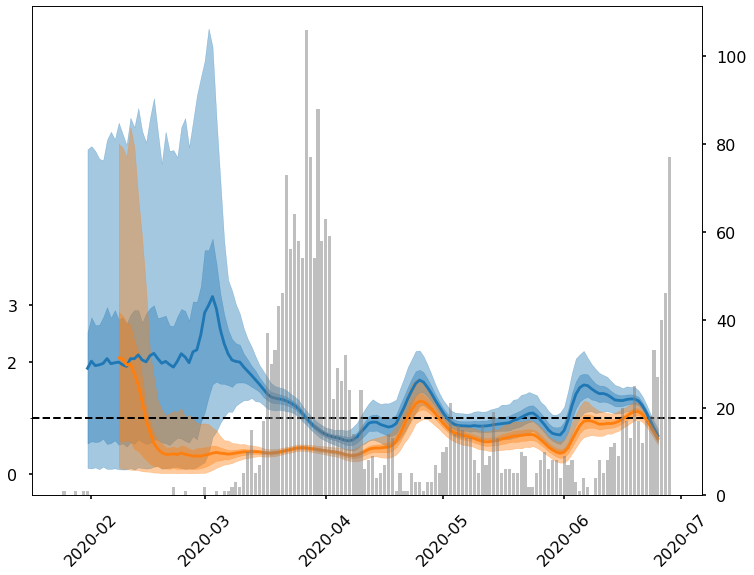

In [29]:
#test run on a state

df_VIC = df_inc_zeros.xs(('VIC','local'),level=('STATE','SOURCE'))
lambda_VIC = generate_lambda(df_VIC.values )


a,b,R = Reff_from_case(df_VIC.values,lambda_VIC,prior_a=1, prior_b=2)

R_summary = generate_summary(R)

fig, ax = plot_Reff(R_summary, dates=df_VIC.index.values[27:])

a,b,R = Reff_from_case(df_VIC.values[8:],lambdas.loc['VIC'].values,prior_a=1, prior_b=2)

R_summary = generate_summary(R)

fig, ax = plot_Reff(R_summary, dates=df_VIC.index.values[35:],ax_arg =(fig,ax))
   #grid line at R_eff =1

ax2 = ax.twinx()
df_cases = df_interim.groupby(['NOTIFICATION_RECEIVE_DATE','STATE']).agg(sum)
df_cases = df_cases.reset_index()
ax2.bar(df_cases.loc[df_cases.STATE=='VIC','NOTIFICATION_RECEIVE_DATE'], 
        df_cases.loc[df_cases.STATE=='VIC','local']+df_cases.loc[df_cases.STATE=='VIC','imported'],
       color='grey',
        alpha=0.5
       )


plt.show()

imported  local
NOTIFICATION_RECEIVE_DATE STATE                 
2020-01-22                NSW           1      0
2020-01-24                NSW           1      0
2020-01-25                NSW           2      0
                          VIC           1      0
2020-01-28                QLD           1      0
...                                   ...    ...
2020-06-26                NSW           4      0
                          VIC           1     39
2020-06-27                NSW           4      0
                          VIC           0     46
2020-06-28                VIC           0     77

[523 rows x 2 columns]

In [ ]:
## plot results


test = np.random.normal(loc=1, scale = 2, size =(30,1000))
test_c = np.cumsum(test, axis=0)

test_sum = generate_summary(test_c)

fig, ax = plot_Reff(test_sum, 
                    dates=pd.date_range(start='2020-03-01', periods=30))

plt.show()